In [1]:
import numpy as np
import math
import time
import matplotlib.pylab as plt
import sys
from IPython import display
from sklearn import datasets
sys.path.append('demo_python_backend_files')

from K_means_methods import K_means_demo, scree_plot
%matplotlib inline

# K-means clustering 

In this notebook we implement the most popular clustering algorithm used in machine learning today- **the K-means algorithm**. We will play around with different input parameters to K-means (e.g., number of clusters, centroid initializations, etc.) in an attempt to understand what can potentially go wrong in applying K-means to clustering tasks. We finally end by giving practical advice on how to avoid these pitfalls.  

>The content of this notebook is supplementary material for the textbook Machine Learning Refined (Cambridge University Press, 2016). Visit http://www.mlrefined.com for free chapter downloads and tutorials, and [our Amazon site here](https://www.amazon.com/Machine-Learning-Refined-Foundations-Applications/dp/1107123526/ref=sr_1_1?ie=UTF8&qid=1474491657&sr=8-1&keywords=machine+learning+refined) for details regarding a hard copy of the text.

## 1. K-means: the model

In Chapter 9 of Machine Learning Refined, available for free download here, we introduce the K-means framework in great detail. Specifically we show that the K-means clustering problem can be modelled as a constrained matrix factorization problem of the form

$$\begin{aligned}\underset{\mathbf{C},\mathbf{W}}{\mbox{minimize}} & \,\,\left\Vert \mathbf{CW}-\mathbf{X}\right\Vert _{F}^{2}\\
\mbox{subject to} & \,\,\,\,\,\mathbf{w}_{p}\in\left\{ \mathbf{e}_{k}\right\} _{k=1}^{K}\,\,\,\forall p=1...P,
\end{aligned}$$

where 

* $\mathbf{X}$ is the $N\times P$ **data matrix**, having $P$ data points (each $N$-dimensional) as columns,

* $K$ is the number of clusters,

* $\mathbf{C}$ is the $N\times K$ **centroid matrix**, containing the centroid locations as columns,

* $\mathbf{W}$ is the $K\times P$ **assignment matrix**, whose $p^{\textrm{th}}$ column $\mathbf{w}_{p}$ is the $p^{\textrm{th}}$ data point's cluster assignment vector and,

* $\mathbf{e}_{k}$ is the $k^{\textrm{th}}$ standard basis vector.  

The reader is strongly encouraged to re-visit **Section 9.1** of [Machine Learning refined](http://mlrefined.wix.com/home-page#!download-sample-chapters/cjg9) for more details regarding how the optimization problem above was derived, as we do not repeat it here. 

## 2. K-means: the algorithm

To solve the K-means optimizaton problem, one can take an alternating minimization approach by alternatingly minimizing the objective function over one of the variables ($\mathbf{C}$ or $\mathbf{W}$), while keeping the other variable fixed. We derived the steps corresponding to this procedure in **Section 9.1.3** of Machine Learning Refined, which for convenience is summarized again below. This simple procedure is often called **the K-means algorithm.**  
<img src="demo_images/K-means_alg.png" width=600 height=350 align=left />

## 3. K-means: the implementation

In this notebook we use the [make_blobs dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) to illustrate how K-means works. Lets load the data first.  

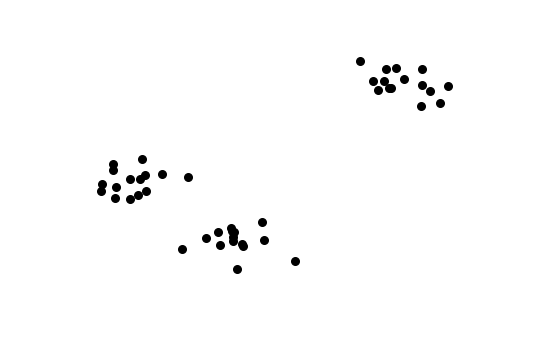

In [2]:
# Loading the data
P = 45 # Number of data points
blobs = datasets.make_blobs(n_samples=P, random_state=1)
X = np.transpose(blobs[0])

# Normalizing data so that all points fall within the unit square (for illustration purposes only)
X = (X-X.min())/(X.max()-X.min())

# Plotting the data
plt.axis('off')
foo = plt.scatter(X[0,:], X[1,:], s=30, color='k')

We now set the number of clusters $K$ and initialize the centroid matrix $\mathbf{C}$.

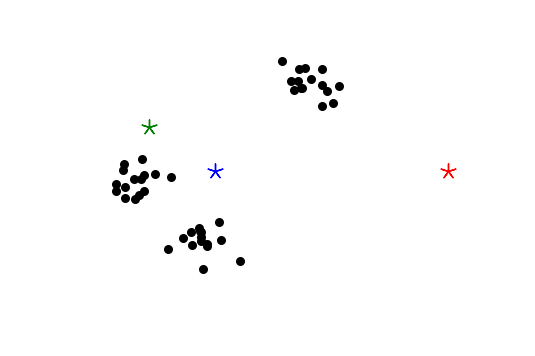

In [3]:
K = 3
C = np.array([[ 1,  .3,  .1],
              [.5,  .5,  .7]])

# Plotting the initial centroid locations relative to the data
clrs = ['r', 'b', 'g', 'm', 'y'] # Colors
plt.axis('off')
foo = plt.scatter(X[0,:], X[1,:], s=30, color='k')
for k in np.arange(0, K):
    foo = plt.scatter(C[0, k], C[1, k], s=120, color=clrs[k], marker=(5, 2))

The [K_means_demo](python_files/K_means_methods.py) method takes in the data matrix $\mathbf{X}$, number of clusters $K$, as well as centroid initializations $\mathbf{C}$, and performs K-means clustering as detailed in **Algorithm 9.1** above. This method has two modes: the <span style="color:maroon">'just_run_the_alg'</span> mode that as its name implies simply runs the K-means algorithm and returns the cluster assignments, and the <span style="color:maroon">'plot_the_steps'</span> mode which additionally plots the centroid and assignment matrix updates at each iteration of the algorithm.     

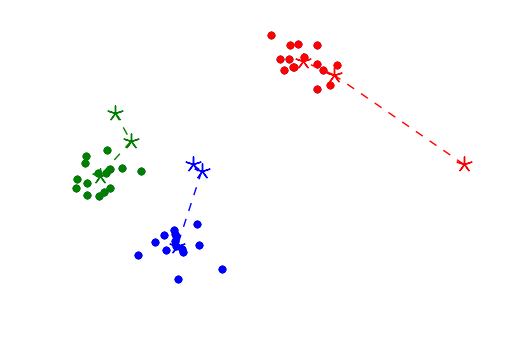

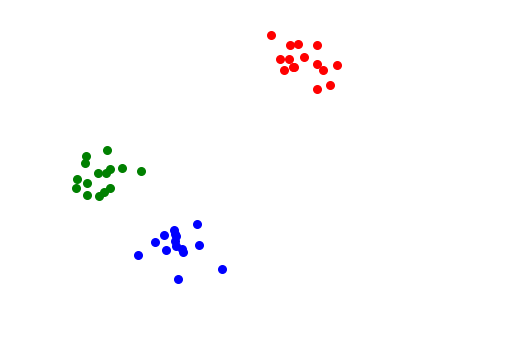

In [4]:
foo, val = K_means_demo(X, K, C, mode='plot_the_steps')   

## 4. K-means: the pitfalls

### 4.1. K-means and non-convexity 
The K-means optimization problem (shown in Section 1 of this notebook) is non-convex, meaning that depending on where the problem is initialized we may end up at a local minimum, producing low-quality clustering results. 

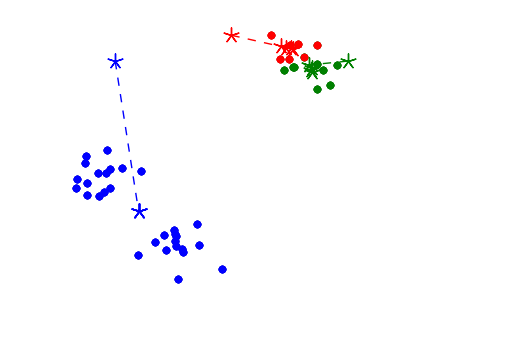

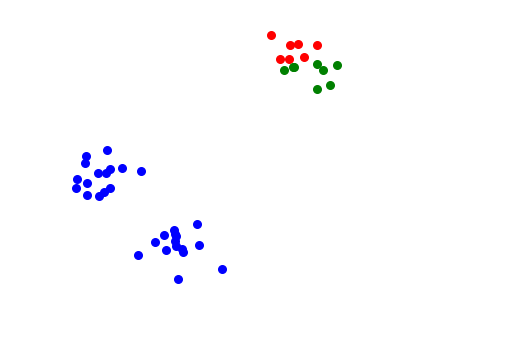

In [5]:
K = 3
C = np.array([[ .4,  .1,  .7],
               [ 1,  .9,  .9]])
foo = K_means_demo(X, K, C, mode='plot_the_steps')      

To avoid this issue one should run K-means multiple times, each time initializing it differently, and pick the run that results in the lowest objective value.  

### 4.2. K-means and empty clusters 
Depending on the centroid initializations, it is possible that one or more of the clusters end up empty.    

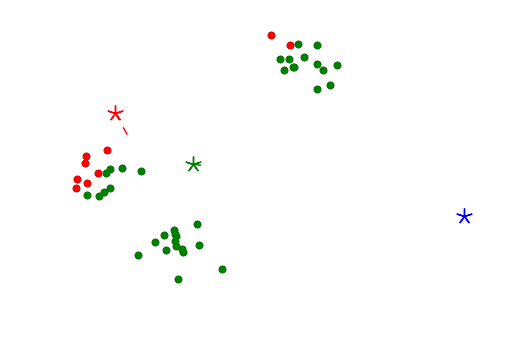

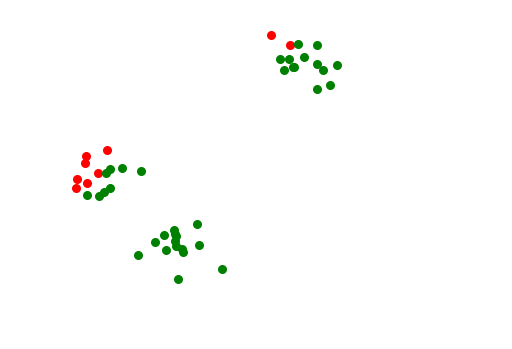

In [6]:
K = 3
C = np.array([[ .1, 1, .3],
              [.7, .3, .5]])
foo = K_means_demo(X, K, C, mode='plot_the_steps') 

Once again running K-means mutiple times will help ameliorate this issue. Additionally, one can tweak the algorithm so that if one cluster ends up with no points, it is automatically assigned one of the points in the dataset at random. Perhaps a better solution is to initialize all cluster centroids in the beginning with actual data points selected at random from the dataset. 

### 4.3. K-means and the choice of K
The choice of $K$ really depends on why we are performing clustering in the first place. Clustering is typically done for one of two reasons:

**(1) As a pre-processing step and to reduce the dimensionality of very large datasets:** today's datasets can be extremely large in terms of number of input data points. By clustering this very large number of data points into a relatively small number of clusters and representing all members of each cluster by that cluster's centroid, we can siginificantly reduce the computational cost of applying more complex machine learning algorithms to very large datasets. 

**(2) To uncover underlyig structures in the data:** sometimes clustering is done not as a pre-processing step in the machine learning pipeline, but to understand the underlying structures in the data. For example, clustering methods have been applied to genetic data in an attempt to help simplify this sort of data for human interpretation. This is important because while there are many genes whose cellular functionalities are well understood by geneticists, the functionality of most remain a mystery. Clustering gene expression data together with the knowledge of the functionality of some members of a gene cluster then give a new insight into the potential functionality of the rest.

When clustering is performed for dimension reduction, the choice of $K$ is determined by the size of the original dataset as well as the capacity of computational resources available at our disposal. On the other hand, when done for uncovering underlying structures in the data and in lack of knowledge/intuition about the correct number of clusters, there is not much we can do but to try different values for $K$ and compare the results. In this case, the objective value of K-means is usually plotted over a range of values for $K$, producing a so-called scree plot.  

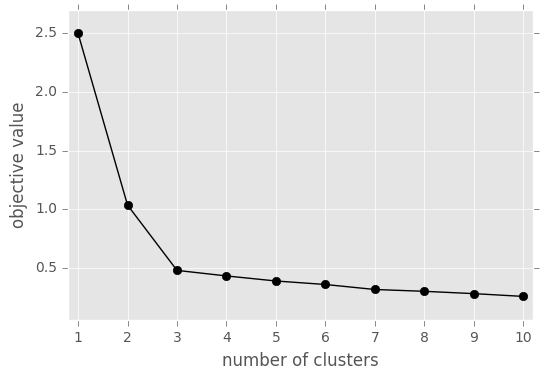

In [7]:
scree_plot(X)

As expected, the objective value monotonically decreases as we increase $K$. Note that the scree plot above has an *elbow* at $K=3$, meaning that increasing the number of clusters from 3 to 4 and onwards reduces the objective value by very little. Therefore one could argue that $K=3$ is the best choice for the number of clusters.   

Lets make the scree plot again, this time for a dataset with $K=5$ clusters. 

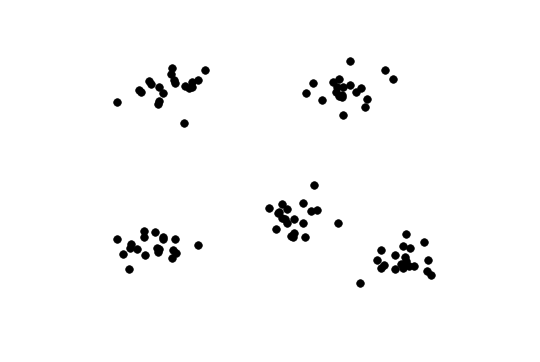

In [8]:
# Loading the data
blobs = datasets.make_blobs(n_samples=100, centers=5, random_state=10)
X = np.transpose(blobs[0])

# Normalizing data so that all points fall within the unit square (for illustration purposes only)
X = (X-X.min())/(X.max()-X.min())

# Plotting the data
plt.axis('off')
foo = plt.scatter(X[0,:], X[1,:], s=30, color='k')

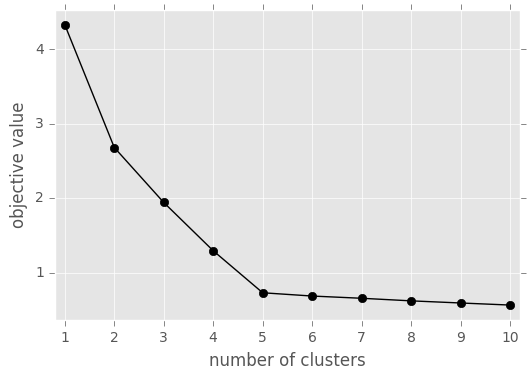

In [9]:
scree_plot(X)